## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


Из личных интересов выберу "Евгения Онегина"

In [47]:
import string
import os
from sklearn.model_selection import train_test_split
import re
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2023-12-11 16:00:41--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-12-11 16:00:41 ERROR 404: Not Found.



FileNotFoundError: ignored

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

### Data loading: "Евгений Онегин"


In [41]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2023-12-11 16:14:46--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.3’

onegin.txt.3        100%[===================>] 256.37K  --.-KB/s    in 0.04s   

2023-12-11 16:14:47 (6.95 MB/s) - ‘onegin.txt.3’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

сразу же избавимся от мусора с помощью регулярных выражений

In [42]:
text = ''.join(text).lower()

text = re.sub('[^\nа-я ]', '', text)
text = re.sub(' +', ' ', text)
text = re.sub('\n\n+', '\n\n', text)
separate_chars = list(filter(bool, text.split('\n\n')))
lines = text.split('\n')
lines = list(filter(bool, lines))

lines хранит списсок из строк. По сути потом именно их мы и будем отправлять в модель

Put all the characters, that you've seen in the text, into variable `tokens`.

In [35]:
tokens = sorted(set(text))

Note: Хорошо почистили текст, избавились от латиницы, остались только пробелы и переносы строк.

In [36]:
print(tokens)

['\n', ' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


Добавим два спец символа в токены для обозначания начала и конца строки

In [37]:
tokens.append('^')
tokens.append('$')

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [38]:
# dict <index>:<char>
token_to_id = {char : i for i, char in enumerate(tokens)}

# dict <char>:<index>
id_to_token = {i : char for i, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [45]:
train_chars, test_chars = train_test_split(separate_chars, test_size=0.2, random_state=69)
train_lines, test_lines = train_test_split(lines, test_size=0.2, random_state=65)

In [48]:
# encode our charactes

def to_matrix(lines, max_len=None):
    """Casts a list of lines into rnn-digestable matrix"""

    max_len = max_len or max(map(len, lines))
    matrix = np.zeros([len(lines), max_len + 2], dtype=int)
    matrix[:, 0] = token_to_id['^']
    for i in range(len(lines)):
        idx = [token_to_id[c] for c in lines[i]]
        matrix[i, 1:len(idx)+1] = idx
        matrix[i, len(idx) + 1:] = token_to_id['$']

    return matrix

to_matrix(lines[: 7])

array([[34, 14, 16, 11,  1,  6, 33,  6, 33,  1, 19,  2, 14, 29, 23,  1,
        25,  7, 19, 20, 15, 29, 23,  1, 17, 18,  2,  4, 10, 13, 35, 35],
       [34, 12, 16,  5,  6,  2,  1, 15,  7,  1,  4,  1, 26, 21, 20, 12,
        21,  1,  9,  2, 15,  7, 14, 16,  5, 35, 35, 35, 35, 35, 35, 35],
       [34, 16, 15,  1, 21,  4,  2,  8,  2, 20, 30,  1, 19,  7,  3, 33,
         1,  9,  2, 19, 20,  2,  4, 10, 13, 35, 35, 35, 35, 35, 35, 35],
       [34, 10,  1, 13, 21, 25, 26,  7,  1,  4, 29,  6, 21, 14,  2, 20,
        30,  1, 15,  7,  1, 14, 16,  5, 35, 35, 35, 35, 35, 35, 35, 35],
       [34,  7,  5, 16,  1, 17, 18, 10, 14,  7, 18,  1,  6, 18, 21,  5,
        10, 14,  1, 15,  2, 21, 12,  2, 35, 35, 35, 35, 35, 35, 35, 35],
       [34, 15, 16,  1,  3, 16,  8,  7,  1, 14, 16, 11,  1, 12,  2, 12,
         2, 33,  1, 19, 12, 21, 12,  2, 35, 35, 35, 35, 35, 35, 35, 35],
       [34, 19,  1,  3, 16, 13, 30, 15, 29, 14,  1, 19, 10,  6,  7, 20,
        30,  1, 10,  1,  6,  7, 15, 30,  1, 10,  1, 15, 16

Отлично, немного изменив функцию из нотбука с класса получаем некоторый аналог эмбедингов для символов

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

Заимпортим торч и будем с ним работать

In [51]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

Построим простую RNN по аналогии с занятия

In [50]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.Sequential(
            nn.Linear(embedding_size + hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        input = self.encoder(input)
        rnn_input = torch.cat([input, hidden], dim=1)
        hidden_next = self.rnn(rnn_input)
        output = self.decoder(hidden_next)
        return hidden_next, output

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

In [53]:
def rnn_batch(char_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hidden = char_rnn.init_hidden(batch_size).to(device)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hidden, output = char_rnn(x_t, hidden)  # <-- here we call your one-step code
        logprobs.append(output)

    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [86]:
model = SimpleRNN(input_size=len(token_to_id))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loader = DataLoader(train_lines, batch_size=30, shuffle=True)

model = model.to(device)

epochs = 50

train_loss = []
test_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(loader):
        batch = to_matrix(data)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        logp_seq = rnn_batch(model, batch, device)
        predictions_logp = logp_seq[:, :-1].contiguous().view(-1, len(tokens))
        actual_next_tokens = batch[:, 1:].flatten()

        loss = criterion(predictions_logp, actual_next_tokens)
        running_loss += loss.item()

        # train with backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        batch = to_matrix(test_lines)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)

        seq = rnn_batch(model, batch, device)
        predictions = seq[:, :-1].contiguous().view(-1, len(tokens))
        actual = batch[:, 1:].flatten()
        test_loss_tmp = criterion(predictions, actual)
        test_loss.append(test_loss_tmp.item() / len(test_lines))

    train_loss_tmp = running_loss / len(loader.dataset)
    train_loss.append(train_loss_tmp)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_tmp}, Test Loss: {test_loss[-1]}')

Epoch [1/50], Train Loss: 0.07584281951437098, Test Loss: 0.0017168638597423133
Epoch [2/50], Train Loss: 0.06617043673212548, Test Loss: 0.0016468603574731051
Epoch [3/50], Train Loss: 0.06388799392936062, Test Loss: 0.0016174601964624208
Epoch [4/50], Train Loss: 0.06275878221895125, Test Loss: 0.001582223992837246
Epoch [5/50], Train Loss: 0.06190048307357589, Test Loss: 0.0015627595634968108
Epoch [6/50], Train Loss: 0.06055043225622914, Test Loss: 0.0015492575250197725
Epoch [7/50], Train Loss: 0.059880391510998596, Test Loss: 0.0015299407474894942
Epoch [8/50], Train Loss: 0.059114990704975286, Test Loss: 0.001501981409783599
Epoch [9/50], Train Loss: 0.05868770463855031, Test Loss: 0.0014845283539122955
Epoch [10/50], Train Loss: 0.05808632546741245, Test Loss: 0.0014957673422737266
Epoch [11/50], Train Loss: 0.05794187626855694, Test Loss: 0.0014836971750730797
Epoch [12/50], Train Loss: 0.057185452389802154, Test Loss: 0.0015097183419724382
Epoch [13/50], Train Loss: 0.0571616

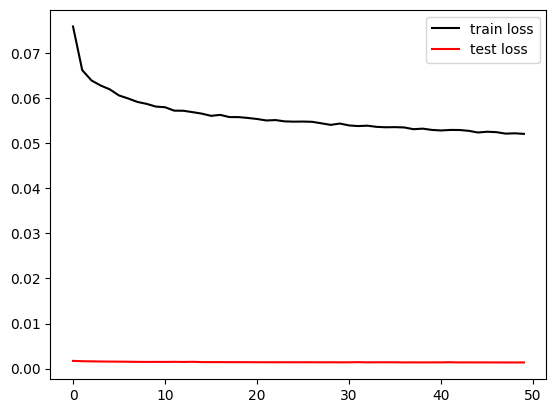

In [87]:
plt.plot(train_loss, label='train loss', color='black')
plt.plot(test_loss, label='test loss', color='red')
plt.legend()
plt.show()

In [93]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.init_hidden(batch_size=1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        out = out.cpu()
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = x_sequence.cpu()
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)


    raw_predict = ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    return raw_predict.replace('^', '').replace('$', '')

In [94]:
for t in [i for i in np.arange(0.1, 3, 0.1)]:
    print('Temperature: ', t)
    for i in range(4):
        model.eval()
        print(generate_sample(model, seed_phrase='^а', max_length=100, temperature=t))

Temperature:  0.1
а то все странный простовой
а пострата с ней постранный
а старины в том не странный
а постранный постранный 
Temperature:  0.2
а сам не все в сердце следный стра
а своей странно молоды
а полно в сердца в сердце все все
а полно в дере странный дель
Temperature:  0.30000000000000004
а невольно пристал он стори
а воль от расседит не скор
а воль весел он вам собранье
а вас он переволодой
Temperature:  0.4
а вс постарины ветстов
а странный поселенный вет
а все в светел и не отвер
а все деревно веста не за
Temperature:  0.5
а потроги ленский мой
а сердит на простовольно
а волскает от пренивал
а преднося до все давно
Temperature:  0.6
а мог об леня в очени
а повер уж теленье новец
а тно к не мне там подоровать
а татьяна то была слада
Temperature:  0.7000000000000001
а бегучит расседело
а ус видет не ветит свет
а в места вс не свете тольба
а прадит гостренной лив
Temperature:  0.8
а стречный душа другов
а прислоть след и тро старенну 
а гошут бадовят плаки
а предкуженся скуже

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [95]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        input = self.encoder(input)
        h_1, c_1 = self.lstm(input, (hidden[0], hidden[1]))
        output = self.decoder(c_1)
        return (h_1, c_1), output

    def init_hidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, requires_grad=True)

Plot the loss function of the number of epochs. Does the final loss become better?

In [97]:
model_lstm = SimpleLSTM(input_size=len(token_to_id))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=0.001)
loader = DataLoader(train_lines, batch_size=30, shuffle=True)

model_lstm = model_lstm.to(device)

epochs = 50

train_loss = []
test_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(loader):
        batch = to_matrix(data)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        logp_seq = rnn_batch(model_lstm, batch, device)
        predictions_logp = logp_seq[:, :-1].contiguous().view(-1, len(tokens))
        actual_next_tokens = batch[:, 1:].flatten()

        loss = criterion(predictions_logp, actual_next_tokens)
        running_loss += loss.item()

        # train with backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        batch = to_matrix(test_lines)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)

        seq = rnn_batch(model_lstm, batch, device)
        predictions = seq[:, :-1].contiguous().view(-1, len(tokens))
        actual = batch[:, 1:].flatten()
        test_loss_tmp = criterion(predictions, actual)
        test_loss.append(test_loss_tmp.item() / len(test_lines))

    train_loss_tmp = running_loss / len(loader.dataset)
    train_loss.append(train_loss_tmp)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_tmp}, Test Loss: {test_loss[-1]}')

Epoch [1/50], Train Loss: 0.07705415389483948, Test Loss: 0.0016921723523520699
Epoch [2/50], Train Loss: 0.06503769838285503, Test Loss: 0.001616061413696057
Epoch [3/50], Train Loss: 0.06289287744606009, Test Loss: 0.0015882751107669148
Epoch [4/50], Train Loss: 0.06187417787830838, Test Loss: 0.0015771362944700872
Epoch [5/50], Train Loss: 0.06121773492992279, Test Loss: 0.0015384218312035041
Epoch [6/50], Train Loss: 0.06039569763451212, Test Loss: 0.0015265317244221503
Epoch [7/50], Train Loss: 0.059959883695550255, Test Loss: 0.0015163299248699
Epoch [8/50], Train Loss: 0.05929199662701837, Test Loss: 0.001513418589254749
Epoch [9/50], Train Loss: 0.05924395658740249, Test Loss: 0.0015083988809766879
Epoch [10/50], Train Loss: 0.05892566650857824, Test Loss: 0.0014933627594559819
Epoch [11/50], Train Loss: 0.05853497794919008, Test Loss: 0.0014869792833074418
Epoch [12/50], Train Loss: 0.058644215332058464, Test Loss: 0.001494319833276843
Epoch [13/50], Train Loss: 0.058249525422

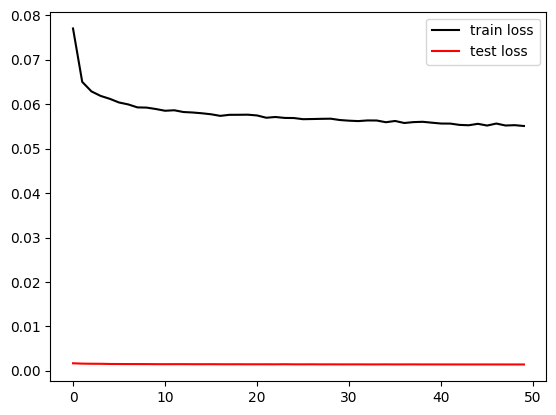

In [98]:
plt.plot(train_loss, label='train loss', color='black')
plt.plot(test_loss, label='test loss', color='red')
plt.legend()
plt.show()

Лосс выглядит примерно также как и для rnn

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [100]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('Temperature: ', t)
    for i in range(4):
        model_lstm.eval()
        print(generate_sample(model_lstm, seed_phrase='^а', max_length=100, temperature=t))

Temperature:  0.1
а так не свет сердце своей
а старен он стари следа
а не стари сердце свет странный
а не старин и старенный стал
Temperature:  0.2
а не свет и старенный стар
а старо страсти полодной
а старой сердце своей сердце
а стари странный стари невой
Temperature:  0.5
а весенный друзь его стором
а староды всед не предене
а дает лино старе слов
а слуши вогдно полсовил
Temperature:  1.0
а вили пои сперен наз
а рушкие сных инегонь
а отежеласьнороюн
а лизный озбучала свод
Temperature:  2.0
атый рармиттурайцишый яцый фререйудрахивмязсамсматън
азлбли ны узрюм ибужьновзстый
ьню свделью т тосто блилаеюмналшепли
абъетсешнюм эюпичоюнкмсдцй ээй тведевнождшьнедп
афмуш зи пок вс люмо рачьзезахпщьемаменмууэфйжюмжю


In [101]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('Temperature: ', t)
    for i in range(4):
        model.eval()
        print(generate_sample(model, seed_phrase='^а', max_length=100, temperature=t))

Temperature:  0.1
а постранный постранный
а воль он в том не постранный
а воль он волно полно
а постранный постранный
Temperature:  0.2
а страсти молодой полно
а него страсти в том не страстей
а все в сердце страсти в том
а полно в дере постренит
Temperature:  0.5
а всех не вак он залевят
а приходил уж из буренье
а давно мило стренят
а постровит на случает
Temperature:  1.0
алягин гак не небизно
а нойны молвенной тромой
а стала как утель яд
асе так разрилося прирета
Temperature:  2.0
альжят нефлудав
цымыхцем 
дамоюа
а стиньъке с поиды ходкуия деми я
асоченпя шискахы дузроньх тимнотряжамью ихолъчтой орпошь
азерщемым сещгустих оздньиъы


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [102]:
torch.save(model, 'model.pt')
torch.save(model_lstm, 'model_lstm.pt')

In [105]:
model_loaded = torch.load('model.pt')
model_lstm_loaded = torch.load('model_lstm.pt')

In [106]:
generate_sample(model_lstm_loaded, seed_phrase='^у', max_length=100, temperature=0.1)

'у старенный полод не свет'

In [107]:
generate_sample(model_loaded , seed_phrase='^у', max_length=100, temperature=0.1)

'уж отверные простов'

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)